In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'
#files are available here https://drive.google.com/drive/folders/1nfQZe8OYJNzGYfV8D3bprSzmFQoSkuaN?usp=share_link

In [ ]:
import os 

In [ ]:
directory = '/content/drive/MyDrive/DL/fish'
train_files = []
target_files = []
fish_types = 'Black Sea Sprat'
for file in os.listdir(os.path.join(directory, fish_types)):
    train_files.append(os.path.join(directory, 'Black Sea Sprat', file))
    target_files.append(os.path.join(directory,  'Black Sea Sprat GT', file))

In [ ]:
df = pd.DataFrame({'img' : train_files, 'mask' : target_files})
df.head()

,img,mask
0,/content/drive/MyDrive/DL/fish/Black Sea Sprat...,/content/drive/MyDrive/DL/fish/Black Sea Sprat...
1,/content/drive/MyDrive/DL/fish/Black Sea Sprat...,/content/drive/MyDrive/DL/fish/Black Sea Sprat...
2,/content/drive/MyDrive/DL/fish/Black Sea Sprat...,/content/drive/MyDrive/DL/fish/Black Sea Sprat...
3,/content/drive/MyDrive/DL/fish/Black Sea Sprat...,/content/drive/MyDrive/DL/fish/Black Sea Sprat...
4,/content/drive/MyDrive/DL/fish/Black Sea Sprat...,/content/drive/MyDrive/DL/fish/Black Sea Sprat...


In [ ]:
df1 = pd.DataFrame()

In [ ]:
from tqdm import tqdm

In [ ]:
(df['img'][0])

'/content/drive/MyDrive/DL/fish/Black Sea Sprat/00001.png'

In [ ]:
img = []
for ind in tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    #origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    img.append(origImage)
df1['img'] = img

100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]


In [ ]:
(df['mask'][0])

'/content/drive/MyDrive/DL/fish/Black Sea Sprat GT/00001.png'

In [ ]:
mask = []
for ind in tqdm(range(len(df['mask']))):
    origImage = cv2.imread(df['mask'][ind])
    #print(origImage)
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    origImage = (origImage ) 
    mask.append(origImage**2)
df1['mask'] = mask

100%|██████████| 1000/1000 [11:57<00:00,  1.39it/s]


In [ ]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img, mask = gen_df.sample(1).values[0]
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            mask =( mask > 0) **2
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
for x, y in keras_generator(df1, 16):
    break

In [ ]:
x.shape

(16, 256, 256, 3)

In [ ]:
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation
from keras.layers import Input, Dense

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [ ]:
from tensorflow import keras

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
df_train = df1

In [ ]:
df1.shape[0]/100*80

800.0

In [ ]:
df_val = df1

In [ ]:
batch_size = 16
model.fit(keras_generator(df_train, batch_size),
              steps_per_epoch=100,
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(df_val, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5
100/100 [==============================] - 46s 261ms/step - loss: 0.2918 - val_loss: 0.1188
Epoch 2/5
100/100 [==============================] - 27s 269ms/step - loss: 0.0933 - val_loss: 0.0641
Epoch 3/5
100/100 [==============================] - 25s 249ms/step - loss: 0.0591 - val_loss: 0.0576
Epoch 4/5
100/100 [==============================] - 25s 250ms/step - loss: 0.0580 - val_loss: 0.0502
Epoch 5/5
100/100 [==============================] - 25s 250ms/step - loss: 0.0551 - val_loss: 0.0490


In [ ]:
pred = model.predict(x)#.shape

1/1 [==============================] - 0s 287ms/step


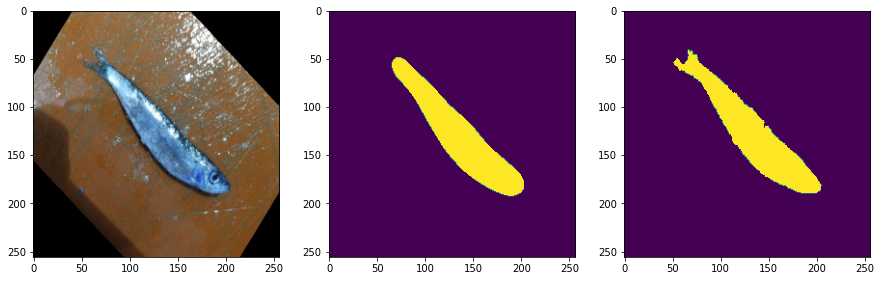

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)
axes[2].imshow(y[im_id, ..., 0])
plt.show()

In [ ]:
#calculate DICE and IoU for 

In [ ]:
len(pred)

16

In [ ]:
m = keras.metrics.MeanIoU(num_classes=16)
m.update_state(pred, y)
iou = m.result().numpy()
iou

0.45035458

In [ ]:
# https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou

dice = 2 * iou / (iou + 1)
dice

0.621026862711705